In [1]:
import pyodbc
import requests
from xml.etree import ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

Starting with data for 2016

Data set IRS 990 forms available via AWS:
 - https://aws.amazon.com/public-datasets/irs-990/

Gather EIN numbers for higher ed institutions in US via
 - https://nces.ed.gov/ipeds/Home/UseTheData

and select appropriate variables. CSV file "CSV_10282017-487/CSV_10282017-487.csv" is the lookup table


In [2]:
ein_dln_df = pd.read_csv("index_2016.csv")
univ_ein_name_df = pd.read_csv("CSV_10282017-487/CSV_10282017-487.csv")

In [3]:
ein_dln_df.head(1)

,RETURN_ID,FILING_TYPE,EIN,TAX_PERIOD,SUB_DATE,TAXPAYER_NAME,RETURN_TYPE,DLN,OBJECT_ID
0,13190365,EFILE,742661023,201412,02/09/2016,HARRIET AND HARMON KELLEY FOUNDATION FOR THE ARTS,990PF,93491315003445,201543159349100344


In [4]:
univ_ein_name_df.head(1)

,unitid,institution name,year,institution name.1,HD2016.Employer Identification Number
0,100654,Alabama A & M University,2016,Alabama A & M University,636001109


In [5]:
ein_to_univ = univ_ein_name_df.rename(columns={'HD2016.Employer Identification Number': 'EIN'})

In [6]:
univ_dln = pd.merge(ein_dln_df,ein_to_univ,on="EIN")  # only get 1105 (others are for-profit)

In [7]:
univ_dln.count()  # a DF with DLN for 2073 higher-ed insitutions in the US

RETURN_ID             1105
FILING_TYPE           1105
EIN                   1105
TAX_PERIOD            1105
SUB_DATE              1105
TAXPAYER_NAME         1105
RETURN_TYPE           1105
DLN                   1105
OBJECT_ID             1105
unitid                1105
institution name      1105
year                  1105
institution name.1    1105
dtype: int64

In [8]:
# All institutions:
xml_to_get = univ_dln.OBJECT_ID

In [9]:
# This is a template for how to get a dataframe of officer compensation by university name:

def get_officers_by_name(name):
    """
    Get a dataframe of paid officers for the institution
    inputs:
        name -> (title case), e.g. Pacific University
                matches institution name field
    """
    if (univ_dln["institution name"] == name).any():
        dln = univ_dln[univ_dln["institution name"] == name]
    elif (univ_dln["institution name"].str.contains(name)).any():
        dln = univ_dln[univ_dln["institution name"].str.contains(name)][0]
    else:
        print("Not Found")
        return []

    ob_id = dln.OBJECT_ID.iloc[0]

    url = "https://s3.amazonaws.com/irs-form-990/" + str(ob_id) + "_public.xml"
    response = requests.get(url)
    root = ET.fromstring(response.content)

    # Modify this to get any other IRS990 info:
    paid_officers = root.findall(".//{http://www.irs.gov/efile}Form990PartVIISectionAGrp")

    df_list = []

    for i,officer in enumerate(paid_officers):  # enumerate so we can index properly
        #print(i[4].text)
        keys = []
        vals = []
        for field in officer:
            #print(field.text)
            keys.append(field.tag[26:])
            vals.append(field.text)

        #print(dict(zip(keys,vals)))
        row = pd.DataFrame(dict(zip(keys,vals)),index=[i])  # have to index with a single item
        df_list.append( row )
        #print(row)
        #df.append(row)

    officers_df = pd.concat(df_list)

    officers_df["Institution"] = name
    
    return officers_df

In [10]:
# This is a template for how to get a dataframe of officer compensation by university name:

def get_officers_by_obid(obid):
    if (univ_dln.OBJECT_ID == obid).any():
        dln = univ_dln[univ_dln.OBJECT_ID == obid]
    else:
        print("Not Found")
        return []

    ob_id = dln.OBJECT_ID.iloc[0]

    url = "https://s3.amazonaws.com/irs-form-990/" + str(ob_id) + "_public.xml"
    response = requests.get(url)
    root = ET.fromstring(response.content)

    # Modify this to get any other IRS990 info:
    paid_officers = root.findall(".//{http://www.irs.gov/efile}Form990PartVIISectionAGrp")

    df_list = []

    for i,officer in enumerate(paid_officers):  # enumerate so we can index properly
        #print(i[4].text)
        keys = []
        vals = []
        for field in officer:
            #print(field.text)
            keys.append(field.tag[26:])
            vals.append(field.text)

        #print(dict(zip(keys,vals)))
        row = pd.DataFrame(dict(zip(keys,vals)),index=[i])  # have to index with a single item
        df_list.append( row )
        #print(row)
        #df.append(row)
        
    if len(df_list) > 0:
        officers_df = pd.concat(df_list)
    else:
        return pd.DataFrame([])

    name = univ_dln[univ_dln.OBJECT_ID == obid]['institution name'].iloc[0]
    officers_df["Institution"] = name
    
    return officers_df

In [11]:
%%time
df_list = []
for obid in xml_to_get:
    try:
        df = get_officers_by_obid(obid)
    except ConnectionError:
        pass
    if not df.empty:
        df_list.append(df)

CPU times: user 1min 14s, sys: 4.63 s, total: 1min 19s
Wall time: 14min 59s


In [12]:
# got most of the records:
len(df_list)

1101

In [13]:
total = pd.concat(df_list)

In [14]:
total.columns

Index(['AverageHoursPerWeekRltdOrgRt', 'AverageHoursPerWeekRt', 'BusinessName',
       'FormerOfcrDirectorTrusteeInd', 'HighestCompensatedEmployeeInd',
       'IndividualTrusteeOrDirectorInd', 'Institution',
       'InstitutionalTrusteeInd', 'KeyEmployeeInd', 'OfficerInd',
       'OtherCompensationAmt', 'PersonNm', 'ReportableCompFromOrgAmt',
       'ReportableCompFromRltdOrgAmt', 'TitleTxt'],
      dtype='object')

### Convert numeric columns to int for proper aggregation.
`df[['col2','col3']] = df[['col2','col3']].apply(pd.to_numeric)`

In [15]:
total['ReportableCompFromOrgAmt'] = total['ReportableCompFromOrgAmt'].apply(pd.to_numeric)

In [19]:
# Find max compensation grouped by institution:
total.groupby('Institution')['ReportableCompFromOrgAmt'].max()

Institution
Abilene Christian University                       263420.0
Adelphi University                                 553588.0
Adrian College                                     729149.0
Adventist University of Health Sciences                 0.0
Agnes Scott College                                267503.0
Alaska Pacific University                          220360.0
Albany College of Pharmacy and Health Sciences     473588.0
Albertus Magnus College                            360889.0
Albion College                                     154239.0
Albright College                                   322348.0
Alderson Broaddus University                       170000.0
Alfred University                                  358977.0
Alice Lloyd College                                154293.0
Allegheny College                                  348833.0
Allen College                                           0.0
Allen University                                   245303.0
Alma College                

In [16]:
total.to_pickle("total1101.pkl")

In [18]:
schoolofficers = total.pivot_table(index='Institution', columns='TitleTxt', values='ReportableCompFromOrgAmt')

In [19]:
# Sorted list of top positions for a given college:

# need to show only nonnull so use dropna:
schoolofficers.loc["Whitman College"].dropna().sort_values(ascending=False)

TitleTxt
President                        372596.0
CFO/Treasurer                    220336.0
Faculty                          210134.6
VP for Development               209663.0
Provost & Dean of the Faculty    186056.0
Dean of Students                 171640.0
Chief Information Officer        157638.0
Vice Chair                            0.0
Trustee                               0.0
Chair                                 0.0
Name: Whitman College, dtype: float64

In [20]:
positions = schoolofficers.transpose()

In [22]:
%matplotlib inline

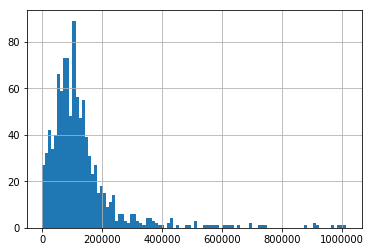

In [23]:
# distribution of mean officer salaries
positions.mean().hist(bins=100)


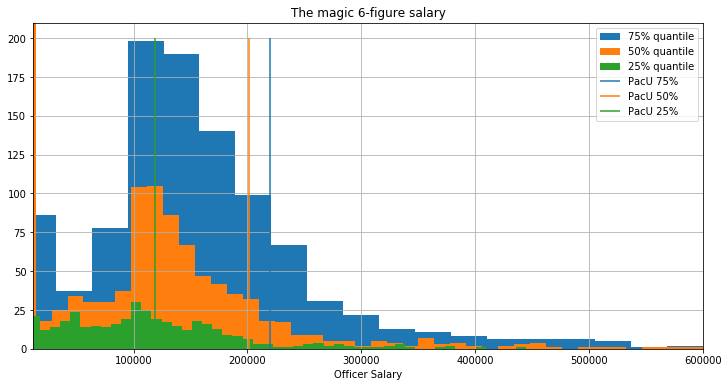

In [42]:
fig = plt.figure(figsize=(12,6))
positions.quantile(0.75).hist(bins=50,label="75% quantile")
positions.quantile(0.5).hist(bins=50,label="50% quantile")
positions.quantile(0.25).hist(bins=50,label="25% quantile")
ax = plt.gca()
ax.vlines(x=positions['Pacific University'].quantile(0.75), ymin=0, ymax=200, color='tab:blue',label="PacU 75%")
ax.vlines(x=positions['Pacific University'].quantile(0.5), ymin=0, ymax=200, color='tab:orange',label="PacU 50%")
ax.vlines(x=positions['Pacific University'].quantile(0.25), ymin=0, ymax=200, color='tab:green',label="PacU 25%")
plt.legend()
plt.ylim([0,210])
plt.xlim([12000,600000])
plt.title("The magic 6-figure salary")
plt.xlabel("Officer Salary")
plt.savefig("officersalary.png")

This graph shows the 75%, 50% and 25% quantiles for officer salaries at US colleges and universities. A few important points: 1) there is a strong pileup at 100k, this reflects the perception that a "six-figure salary" indicates status in the position. Above that point, there is rapid decay with an extremely long tail. A specific institution, in this case "Pacific University" is added so the officer salary quantiles can be compared to the national distribution. In this case, it appears safe to say that most PacU officers are paid very highly, though the bottom 25% are in line with the national distribution. 

The long-tail outliers are often special cases, but still deserve some attention. In particular, we need to ask: "Shy pay so much?" and "What metrics improve for an institution that pays officers so highly?"


## Next steps:
 - pull more IRS990 fields: total expenses, instructional expenses, salary expenses
 - calculate metrics for each as fraction of total, fraction of tuition, etc
 
## Longer-term goals:
 - track vs. time by pulling prior IRS990 years. Tricky due to different XML formats. Some help found here: http://990.charitynavigator.org/